In [1]:
from langchain_openai import OpenAIEmbeddings
import os

embeddings = OpenAIEmbeddings(
    base_url="https://models.inference.ai.azure.com",
    api_key=os.environ["GITHUB_API_KEY"],
    model="text-embedding-3-large"
)

In [3]:
import os
from langchain_pinecone import PineconeVectorStore

os.environ['PINECONE_API_KEY'] = os.getenv("PINECONE_API_KEY")

index_name = "docs"

vector_store = PineconeVectorStore(index_name=index_name, embedding=embeddings)

def build_retriever(chat_args):
    search_kwargs = {"filter": {"pdf_id": chat_args.pdf_id}}

    return vector_store.as_retriever(
        search_kwargs=search_kwargs
    )

In [2]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore

import sys


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
) 

loader = PyPDFLoader("008_spice.pdf")
docs = loader.load_and_split(text_splitter)

splits = text_splitter.split_documents(docs)
vectorstore = InMemoryVectorStore.from_documents(
    documents=splits, embedding=embeddings
)
retriever = vectorstore.as_retriever()

In [3]:
print(docs)

[Document(metadata={'source': '008_spice.pdf', 'page': 0}, page_content='Spices\nSpices at a central market in Agadir,\nMorocco\nA group of Indian herbs and spices in\nbowls\nSpices of Saúde flea market, São\nPaulo, BrazilSpice\nA spice is a seed, fruit, root, bark, or other plant substance\nprimarily used for flavoring or coloring food. Spices are\ndistinguished from herbs, which are the leaves, flowers, or stems of\nplants used for flavoring or as a garnish. Spices are sometimes used\nin medicine, religious rituals, cosmetics, or perfume produc tion.'), Document(metadata={'source': '008_spice.pdf', 'page': 0}, page_content='in medicine, religious rituals, cosmetics, or perfume produc tion.\nFor example, vanilla is commonly used as an ingredient in\nfragrance manufacturing.[1]\nA spice may be available in several forms: fresh, whole-dried, or\npre-ground dried. Generally, spices are dried. Spices may be\nground into a powder for conve nience. A whole dried spice has the\nlonge st shel

In [3]:
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain_community.document_loaders import PyPDFLoader
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict
from typing import Sequence
import os
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    base_url="https://models.inference.ai.azure.com",
    api_key=os.environ["GITHUB_API_KEY"],
    model="text-embedding-3-large"
)

llm = ChatOpenAI(
    model="gpt-4o-mini",
    base_url="https://models.inference.ai.azure.com",
    api_key=os.environ.get("GITHUB_API_KEY")
)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
) 

loader = PyPDFLoader("008_spice.pdf")
docs = loader.load_and_split(text_splitter)

splits = text_splitter.split_documents(docs)
vectorstore = InMemoryVectorStore.from_documents(
    documents=splits, embedding=embeddings
)
retriever = vectorstore.as_retriever()

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

### Answer question ###
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


### Statefully manage chat history ###
class State(TypedDict):
    input: str
    chat_history: Annotated[Sequence[BaseMessage], add_messages]
    context: str
    answer: str


def call_model(state: State):
    response = rag_chain.invoke(state)
    return {
        "chat_history": [
            HumanMessage(state["input"]),
            AIMessage(response["answer"]),
        ],
        "context": response["context"],
        "answer": response["answer"],
    }

workflow = StateGraph(state_schema=State)
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [4]:
config = {"configurable": {"thread_id": "abc123"}}

result = app.invoke(
    {"input": "Which country produces most spices?"},
    config=config,
)
print(result["answer"])

India produces the most spices, contributing to 75% of global spice production. In 2011, it produced 1,525,000 metric tonnes.


In [5]:
result = app.invoke(
    {"input": "How much they produce?"},
    config=config,
)
print(result["answer"])

In 2011, India produced 1,525,000 metric tonnes of spices.


In [6]:
print(result)

{'input': 'How much they produce?', 'chat_history': [HumanMessage(content='Which country produces most spices?', additional_kwargs={}, response_metadata={}, id='f2a413f6-67f8-4ba1-8fe7-0fb6243807b5'), AIMessage(content='India produces the most spices, contributing to 75% of global spice production. In 2011, it produced 1,525,000 metric tonnes.', additional_kwargs={}, response_metadata={}, id='683ff3dd-feb3-44c2-b9ac-1a13c7152043'), HumanMessage(content='How much they produce?', additional_kwargs={}, response_metadata={}, id='a227f23d-e582-4529-b8c6-306aec79223b'), AIMessage(content='In 2011, India produced 1,525,000 metric tonnes of spices.', additional_kwargs={}, response_metadata={}, id='87edc17a-ca8d-4459-9e86-9ab65d2d498b')], 'context': [Document(id='3115be65-0920-4ade-abe1-5c10286beb53', metadata={'source': '008_spice.pdf', 'page': 5}, page_content='Spices and herbs at a shop in Goa,\nIndiaTop Spice Producing Countries\n(in metric tonnes)\nRank Country 2010 2011\n1 India 1,474,900

In [2]:
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain_community.document_loaders import PyPDFLoader
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict
from typing import Sequence
import os
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    base_url="https://models.inference.ai.azure.com",
    api_key=os.environ["GITHUB_API_KEY"],
    model="text-embedding-3-large"
)

llm = ChatOpenAI(
    model="gpt-4o-mini",
    base_url="https://models.inference.ai.azure.com",
    api_key=os.environ.get("GITHUB_API_KEY")
)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
) 

# loader = PyPDFLoader("008_spice.pdf")
# docs = loader.load_and_split(text_splitter)

# splits = text_splitter.split_documents(docs)
# vectorstore = InMemoryVectorStore.from_documents(
#     documents=splits, embedding=embeddings
# )
# retriever = vectorstore.as_retriever()

from langchain_pinecone import PineconeVectorStore

os.environ['PINECONE_API_KEY'] = os.getenv("PINECONE_API_KEY")

index_name = "docs"

vector_store = PineconeVectorStore(index_name=index_name, embedding=embeddings)

search_kwargs = {"filter": {"pdf_id": "b5f7841d-6055-4c36-a394-01d6ee276b7f"}}

retriever = vector_store.as_retriever(search_kwargs=search_kwargs)



contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

### Answer question ###
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


### Statefully manage chat history ###
class State(TypedDict):
    input: str
    chat_history: Annotated[Sequence[BaseMessage], add_messages]
    context: str
    answer: str


def call_model(state: State):
    response = rag_chain.invoke(state)
    return {
        "chat_history": [
            HumanMessage(state["input"]),
            AIMessage(response["answer"]),
        ],
        "context": response["context"],
        "answer": response["answer"],
    }

workflow = StateGraph(state_schema=State)
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

USER_AGENT environment variable not set, consider setting it to identify your requests.
h:\GitHub_of_104\PDF_LangChain\.venv\Lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


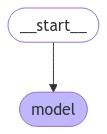

In [3]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [5]:
config = {"configurable": {"thread_id": "abc123"}}


In [6]:
result = app.invoke(
    {"input": "Which country produces most spices?"},
    config=config,
)
print(result["answer"])

India produces the most spices, contributing to 75% of global spice production. In 2011, it produced approximately 1,525,000 metric tonnes of spices.


In [7]:
print(result)

{'input': 'Which country produces most spices?', 'chat_history': [HumanMessage(content='Which country produces most spices?', additional_kwargs={}, response_metadata={}, id='9a5c64a8-a3b2-4269-9cc1-dc9d3d7ddb84'), AIMessage(content='India produces the most spices, contributing to 75% of global spice production. In 2011, it produced approximately 1,525,000 metric tonnes of spices.', additional_kwargs={}, response_metadata={}, id='17ab34e3-0bc2-449b-9145-c480df3cdd9a')], 'context': [Document(id='ba10cb75-d8d9-4200-b8ed-92ba118172af', metadata={'page': 5.0, 'pdf_id': 'b5f7841d-6055-4c36-a394-01d6ee276b7f'}, page_content='Spices and herbs at a shop in Goa,\nIndiaTop Spice Producing Countries\n(in metric tonnes)\nRank Country 2010 2011\n1 India 1,474,9001,525,000\n2 Bangladesh128,517 139,775\n3 Turkey 107,000 113,783\n4 China 90,000 95,890\n5 Pakistan 53,647 53,620\n6 Iran 18,028 21,307\n7 Nepal 20,360 20,905\n8 Colombia 16,998 19,378\n9 Ethiopia 27,122 17,905\n10 Sri Lanka 8,293 8,438\n— W

In [4]:
result = app.invoke(
    {"input": "How much they produce in 2010?"},
    config=config,
)
print(result["answer"])

In 2010, India produced 1,474,900 metric tonnes of spices.


In [5]:
print(result)

{'input': 'How much they produce in 2010?', 'chat_history': [HumanMessage(content='Which country produces most spices?', additional_kwargs={}, response_metadata={}, id='cf627642-61d2-4cc0-9113-ea2027776c67'), AIMessage(content='India is the largest producer of spices, contributing to 75% of global spice production. In 2010, India produced 1,474,900 metric tonnes of spices.', additional_kwargs={}, response_metadata={}, id='5db2e6c5-e514-45ec-be84-21bc76d00e67'), HumanMessage(content='How much they produce in 2010?', additional_kwargs={}, response_metadata={}, id='6bc582b4-d0f5-4a9d-b22b-b6a9d1f17035'), AIMessage(content='In 2010, India produced 1,474,900 metric tonnes of spices.', additional_kwargs={}, response_metadata={}, id='31d73b3a-c4a5-40b5-ba0a-391c079c3959')], 'context': [Document(id='0be7cdc5-069f-42b9-ab14-c6587e050e7a', metadata={'page': 5.0, 'pdf_id': '30c50f31-d6f0-4697-a989-fe88e998a9dc'}, page_content='Spices and herbs at a shop in Goa,\nIndiaTop Spice Producing Countries

In [14]:
for chunk in result:
    print(chunk)

{'model': {'chat_history': [HumanMessage(content='How much they produce in 2010?', additional_kwargs={}, response_metadata={}, id='cd86f1b6-f36f-431d-8d88-b439f171fff7'), AIMessage(content="In 2010, India produced about 7.5 million metric tons of spices. This included a diverse range of spices, reinforcing India's status as the leading producer globally.", additional_kwargs={}, response_metadata={}, id='79fc56f7-b241-4228-8fcd-7ee1129099f8')], 'context': [], 'answer': "In 2010, India produced about 7.5 million metric tons of spices. This included a diverse range of spices, reinforcing India's status as the leading producer globally."}}


In [8]:
for chunk in app.stream(
    {"input": "Which country produces most spices?"},
    config=config,
):
    print(chunk)

{'model': {'chat_history': [HumanMessage(content='Which country produces most spices?', additional_kwargs={}, response_metadata={}, id='94fabe84-080f-44f0-b99e-c0761d4b82c4'), AIMessage(content='India produces the most spices, contributing to 75% of global spice production.', additional_kwargs={}, response_metadata={}, id='01bcfc60-5806-4898-8b76-d9c0ebfadc9f')], 'context': [Document(id='ba10cb75-d8d9-4200-b8ed-92ba118172af', metadata={'page': 5.0, 'pdf_id': 'b5f7841d-6055-4c36-a394-01d6ee276b7f'}, page_content='Spices and herbs at a shop in Goa,\nIndiaTop Spice Producing Countries\n(in metric tonnes)\nRank Country 2010 2011\n1 India 1,474,9001,525,000\n2 Bangladesh128,517 139,775\n3 Turkey 107,000 113,783\n4 China 90,000 95,890\n5 Pakistan 53,647 53,620\n6 Iran 18,028 21,307\n7 Nepal 20,360 20,905\n8 Colombia 16,998 19,378\n9 Ethiopia 27,122 17,905\n10 Sri Lanka 8,293 8,438\n— World 1,995,5232,063,472'), Document(id='1cec5c78-6870-47e1-846b-10f3eba4ed68', metadata={'page': 0.0, 'pdf_i

In [2]:
from langchain_openai import ChatOpenAI
import os


# llm = ChatOpenAI(
#     model="gpt-4o-mini",
#     base_url="https://models.inference.ai.azure.com",
#     api_key=os.environ.get("GITHUB_API_KEY")
# )

llm = ChatOpenAI(
    model='Meta-Llama-3.1-405B-Instruct',
    base_url="https://api.sambanova.ai/v1",
    api_key=os.environ.get("SAMBANOVA_API_KEY"),
)

In [3]:
for chunk in llm.stream("Write me a 1 verse song about goldfish on the moon"):
    print(chunk.content, flush=True)


"On 
the moon's 
pale 
silvery 
floor,
A 
secret 
aquarium waits in 
store,
Goldfish swim 
in 
weightless delight,
Their 
scales shining bright in 
lunar light."




In [4]:
llm.stream("Write me a 1 verse song about goldfish on the moon")

<generator object BaseChatModel.stream at 0x000002318F8DB6E0>